In [1]:
import time
from typing import Any

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
    recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Things that belong to strongly predictions, we just remove this
exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']

# Define nominal and binary columns
# numeric is calculated using above 2.
nominal = ['protocol_type', 'service', 'flag']
binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']


def define_numeric_column(data: pd.DataFrame) -> list[Any]:
    # Define numeric columns dynamically based on the dataframe
    return [col for col in data.columns if col not in nominal + binary + exclusion_list]


def print_score():
    # Calculate other evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"SIMPLE DECISION TREE")
    print("===========================================================================")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    print("Decision Tree Model Evaluation:")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")

    # Print confusion matrix with class labels
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_names = np.unique(y)
    print("\nConfusion Matrix with Class Labels:")
    print(pd.DataFrame(conf_matrix, index=class_names, columns=class_names))


def check_fitting():
    print("\nOverfitting/Underfitting Diagnosis:")
    if train_accuracy > test_accuracy + 0.05:  # Arbitrary threshold (e.g., 5% gap)
        print("Possible Overfitting: Training accuracy is significantly higher than testing accuracy.")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:  # Arbitrary low threshold
        print("Possible Underfitting: Both training and testing accuracies are low.")
    else:
        print("Good Fit: Training and testing accuracies are reasonably close.")


def preprocess_data(data: pd.DataFrame) -> tuple:
    data = data.copy()
    # Data cleaning
    data['su_attempted'] = data['su_attempted'].replace({2: 0}, inplace=False)
    # Define columns
    numeric = define_numeric_column(data)
    return data[nominal + numeric + binary], data['attack_category']


def label_encode_nominal_data(features: pd.DataFrame):
    for col in nominal:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col])


df = pd.read_csv('./data/kdd_merged.csv')
X, y = preprocess_data(df)

label_encode_nominal_data(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on both training and testing sets
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print_score()
check_fitting()


SIMPLE DECISION TREE

Classification Report:
               precision    recall  f1-score   support

      benign       0.99      0.99      0.99     15411
         dos       1.00      1.00      1.00     10713
       probe       0.99      0.99      0.99      2816
         r2l       0.97      0.97      0.97       714
         u2r       0.74      0.78      0.76        50

    accuracy                           0.99     29704
   macro avg       0.94      0.95      0.94     29704
weighted avg       0.99      0.99      0.99     29704

Decision Tree Model Evaluation:
Training Time: 2.2603 seconds
Training Accuracy: 0.9994
Testing Accuracy: 0.9941
Precision (Weighted): 0.9942
Recall (Weighted): 0.9941
F1-Score (Weighted): 0.9942

Confusion Matrix with Class Labels:
        benign    dos  probe  r2l  u2r
benign   15333     37     17   15    9
dos         36  10675      2    0    0
probe       16      3   2790    5    2
r2l         18      0      0  693    3
u2r          8      0      1    2   3

Decision Tree Visualization

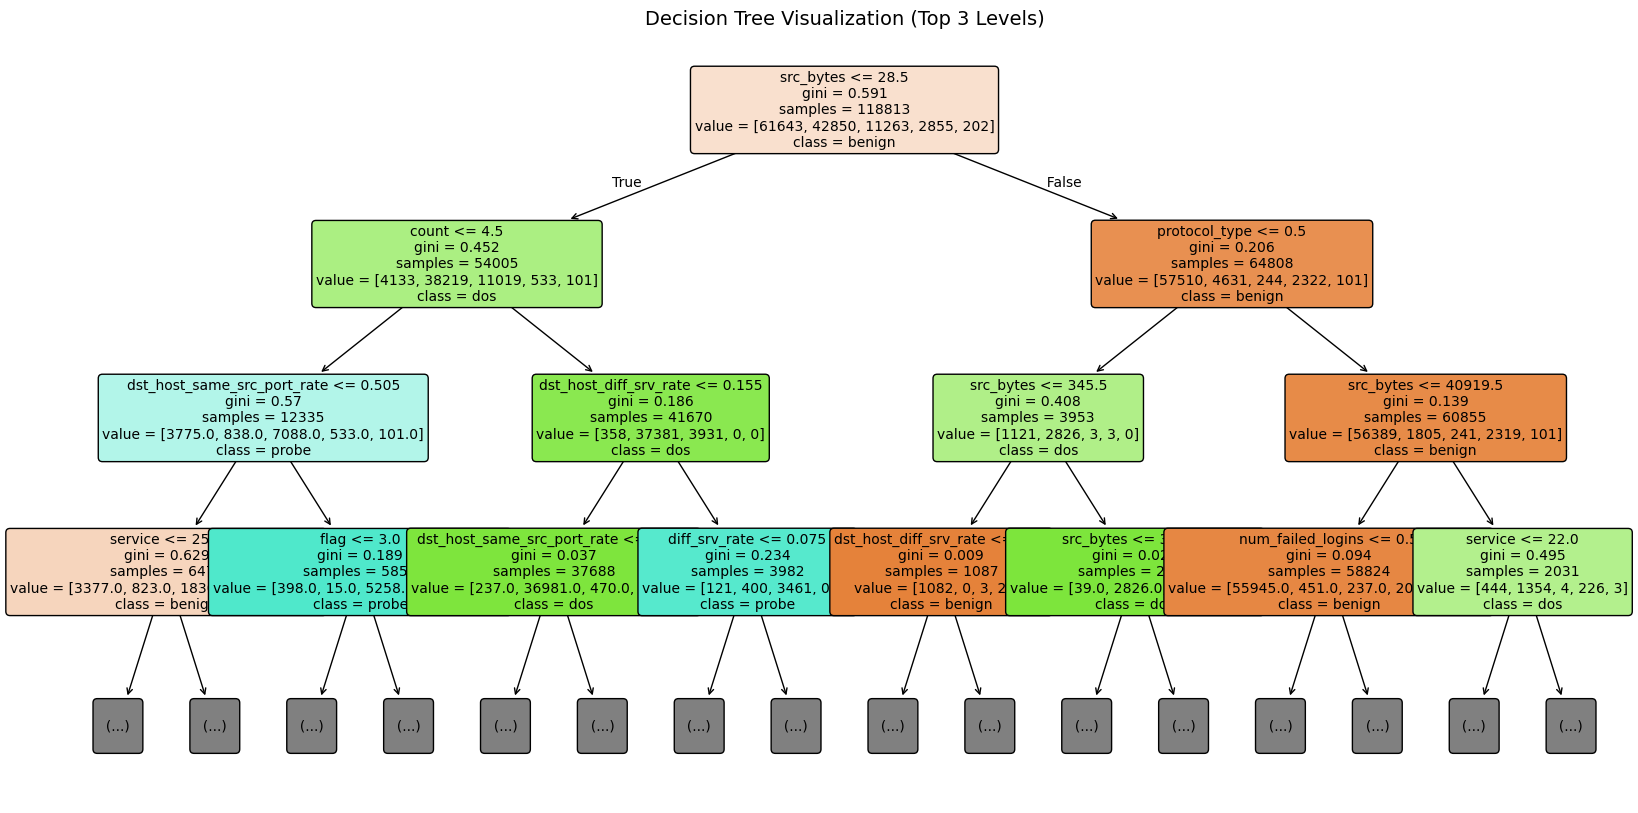

In [5]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns.tolist(), class_names=np.unique(y).tolist(), filled=True,
          rounded=True, fontsize=10, max_depth=3)
plt.title("Decision Tree Visualization (Top 3 Levels)", fontsize=14)
plt.show()

ROC Curve


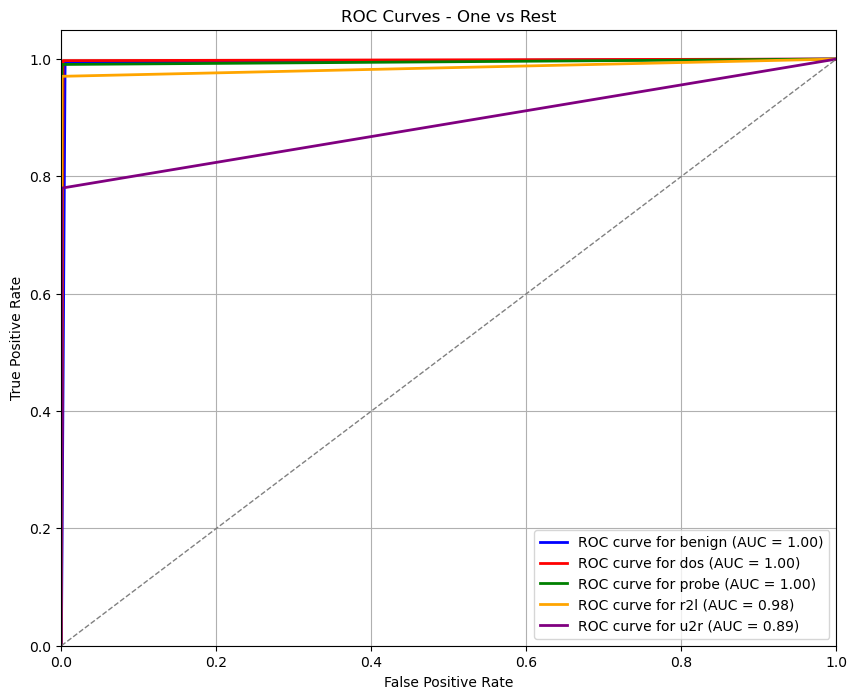

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get unique classes
classes = np.unique(y)
n_classes = len(classes)

# Binarize y_test for multi-class ROC
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_test_prob = dt_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust for your number of classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - One vs Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()